# Chainer Hands-on: Introduction To Train Deep Learning Model in Python

## Goal

Play with neural networks using Chainer in image recognition.

## Lessons to be learned

Attendees will learn the following features of Chainer.

1. Easy debug
2. CPU/GPU-compatible array manipulation

## Agenda

### Section 1. MNIST Classification by Perceptron

Simple neural networks to classify hand-written digit images

* Defining and training multi-layer perceptron
* Evaluating and visualizing result 
* Model improvement and debugging

### Section 2. Inside Chainer

Summary of features, class structures and implementations

* NumPy and CuPy
* Variable and Function
* Link and Chain
* Define-by-Run

## Note

We assume that Chainer 1.20.0.1 is installed on a CUDA-7.0-enabled environment for this jupyter notebook. 



## Preparation: Chainer import

First, import Chainer and related modules. CuPy will be introduced later.

In [1]:
# Import Chainer 
from chainer import Chain, Variable, optimizers, serializers, datasets, training
from chainer.training import extensions
import chainer.functions as F
import chainer.links as L
import chainer

# Import NumPy and CuPy
import numpy as np
import cupy as cp

# Utilities
import time
import math

print('Chainer version: ', chainer.__version__)

('Chainer version: ', '1.20.0.1')


# Section 1. MNIST Classification by Perceptron

MNIST is a benchmark classification dataset in machine learning. It contains 70,000 hand-written digit images. Labels (0-9) are also provided (10-class classification problem). The task is to predict which digit given images belongs to.

<img src="image/mnist.png">

Each sample is represented as 28x28 gray scale image (784 dimensional vector)

### Definition: multi-layer perceptron (2-layer)

As the most simple neural network model, we use a multi-layer perceptron of size 2 (MLP2). It consists of input, output, and one hidden unit between them. They are connected with linear layers (fully-connected layers), which contain weight matrix and bias term, respectively. The activation function for the hidden unit is hyperbolic tangent (tanh).

<img src="image/mlp_tanh.png" width="600" >

The following class implements MLP2. Note that only the type and size of each layer is defined in ``__init__`` method. The actual forward computation is directly written in a separate ``__call__`` method. On the other hand, there is no explicit definition of backward computation, since Chainer remembers the computational graph in forward computation and backward computation can be done along it (described in Section 2).

In [2]:
# 2-layer Multi-Layer Perceptron (MLP)
class MLP2(Chain):
    
    # Initialization of layers
    def __init__(self):
        super(MLP2, self).__init__(
            l1=L.Linear(784, 100),  # From 784-dimensional input to hidden unit with 100 nodes 
            l2=L.Linear(100, 10),  # From hidden unit with 100 nodes to output unit with 10 nodes  (10 classes)
        )

    # Forward computation by __call__
    def __call__(self, x):
        h1 = F.tanh(self.l1(x))     # Forward from x to h1 through activation with tanh function 
        y = self.l2(h1)                 # Forward from h1to y
        return y

### Preparation: MNIST dataset load & pre-processing

MNIST dataset can be loaded into main memory by chainer.datasets.get_mnist().

Following the standard problem setting of MNIST, we divide 70,000 samples into the training image-label pairs, train of size 60,000, and the testing pairs test, of size 10,000.

In [3]:
train, test = chainer.datasets.get_mnist()
print('Train:', len(train))
print('Test:', len(test))

('Train:', 60000)
('Test:', 10000)


### Preparation: experimental setup

These variables will be used throughout the experiments.

In [4]:
batchsize=100

## Experiment 1.1 - CPU-based training of MLP2

As the initial setting, we use NumPy for CPU-based execution. Number of epochs (how many times each training sample will be used) is set to 2. 

In [5]:
enable_cupy = False # No CuPy (Use NumPy)
n_epoch=2 # Only 2 epochs
model = MLP2() # MLP2 model

### Definition: method for MNIST train and test

The following train_and_test() actually run the experiments by using [Trainer](http://docs.chainer.org/en/stable/tutorial/basic.html#trainer) that was introduced from Chainer v1.11.0. It contains the last 3 parts of the standard ML workflow below.

<img src="image/ml_flow.png" width="600">

Optimizer will be used during the model training to update the model parameters (weight matrix and bias term for linear layer) through back propagation. Chainer supports most of the widely-used [optimizers](http://docs.chainer.org/en/stable/reference/optimizers.html#optimizers) (SGD, AdaGrad, RMSProp, Adam, etc...). Here we use SGD. [L.Classifier](https://github.com/pfnet/chainer/blob/master/chainer/links/model/classifier.py) is a wrapper to build a classification model using a neural network, which is MLP2 in this setting. The default loss for L.Classifier is softmax cross entropy.

In [6]:
def  train_and_test():
    training_start = time.clock()
    log_trigger = 600, 'iteration'
    classifier_model = L.Classifier(model.copy())
    device = -1
    if enable_cupy:
        model.to_gpu()
        chainer.cuda.get_device(0).use()
        device = 0
    optimizer = optimizers.SGD()
    optimizer.setup(classifier_model)
    train_iter = chainer.iterators.SerialIterator(train, batchsize)
    test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
    updater = training.StandardUpdater(train_iter, optimizer, device=device)
    trainer = training.Trainer(updater, (n_epoch, 'epoch'), out='out')
    trainer.extend(extensions.dump_graph('main/loss'))
    trainer.extend(extensions.Evaluator(test_iter, classifier_model, device=device))
    trainer.extend(extensions.LogReport(trigger=log_trigger))
    trainer.extend(extensions.PrintReport(
        ['epoch', 'iteration', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy']), trigger=log_trigger)
    trainer.run()
    elapsed_time = time.clock() - training_start
    print('Elapsed time: %3.3f' % elapsed_time)

### Execution: wait until test finishes

Let's run the experiment and get the first result. It takes 30 seconds or so.

In [7]:
train_and_test() # May take 30 sec or more

epoch       iteration   main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1           600         1.12999     0.647224              0.753417       0.8605                    
2           1200        0.561729    0.470437              0.86565        0.8843                    
Elapsed time: 28.548


### Evaluation: see the 1st result

The validation/main/accuracy should be less than 0.90. This is not bad, but can be improved. Later we will try other settings.

### Preparation: import visualization tools

We use matplotlib to display computational graphs and MNIST images.

In [8]:
# Import utility and visualization tools
import pydot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display
import chainer.computational_graph as cg

### Definition: method for visualizing computational graph

Chainer can export the computational graph from input to the loss function.

In [9]:
def display_graph():
    graph = pydot.graph_from_dot_file('out/cg.dot') # load from .dot file
    graph[0].write_png('graph.png')

    img = Image('graph.png', width=600, height=600)
    display(img)

### Execution: visualize the computational graph of MLP2

By running display_graph(), a directed graph will be shown. Three ellipsoids on top correspond to the input 100 images with 784 dimensions,  weight matrix of size 100x784, and the bias term vector of length 100 for a linear layer.

The intermediate hidden unit with 100 nodes will be transferred to the next linear layer through a tanh activation function. The final 100 vectors for 10 classes are compared to the answers of int32 with SoftmaxCrossEntropy loss function. The loss value is given as a float32 value.

After building this graph, the backpropagation can work from the loss back to the input  to update the model parameters (the weight matrices and bias terms of two LinearFunction).

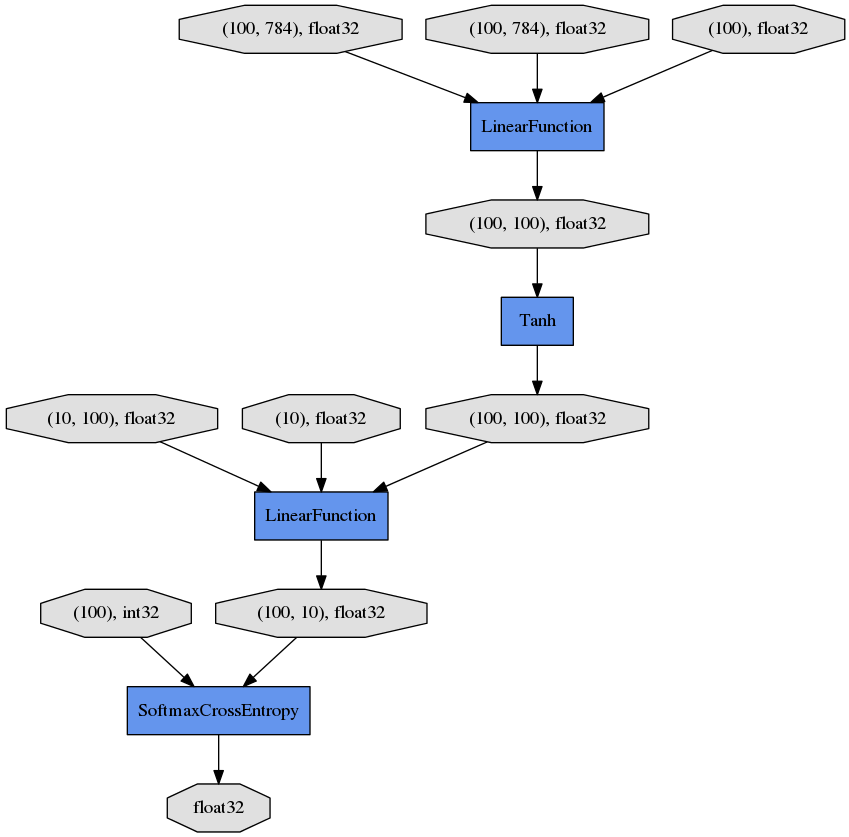

In [10]:
display_graph()

### Definition: method for plotting images with predictions

"Answer'" is the ground truth given in the dataset, and "Predict:" gives the prediction by the current model.

In [11]:
def plot_examples():
    %matplotlib inline
    plt.figure(figsize=(12,50))
    if enable_cupy:
       model.to_cpu()
    for i in range(45, 105): 
        x = Variable(np.asarray([test[i][0]]))  # test data
        t = Variable(np.asarray([test[i][1]]))  # labels
        y = model(x)
        prediction = y.data.argmax(axis=1)
        example = (test[i][0] * 255).astype(np.int32).reshape(28, 28)
        plt.subplot(20, 5, i - 44)
        plt.imshow(example, cmap='gray')
        plt.title("No.{0} / Answer:{1}, Predict:{2}".format(i, t.data[0], prediction[0]))
        plt.axis("off")
    plt.tight_layout()

### Execution: see some of examples are misclassified

Though most of the samples are correctly classified, there can be some mistakes. For example, No. 46 on the first row might be classified as '3', though it looks '1' to humans. The current model may also misclassify No.54 on the second row as '2', which is a strange '6'.

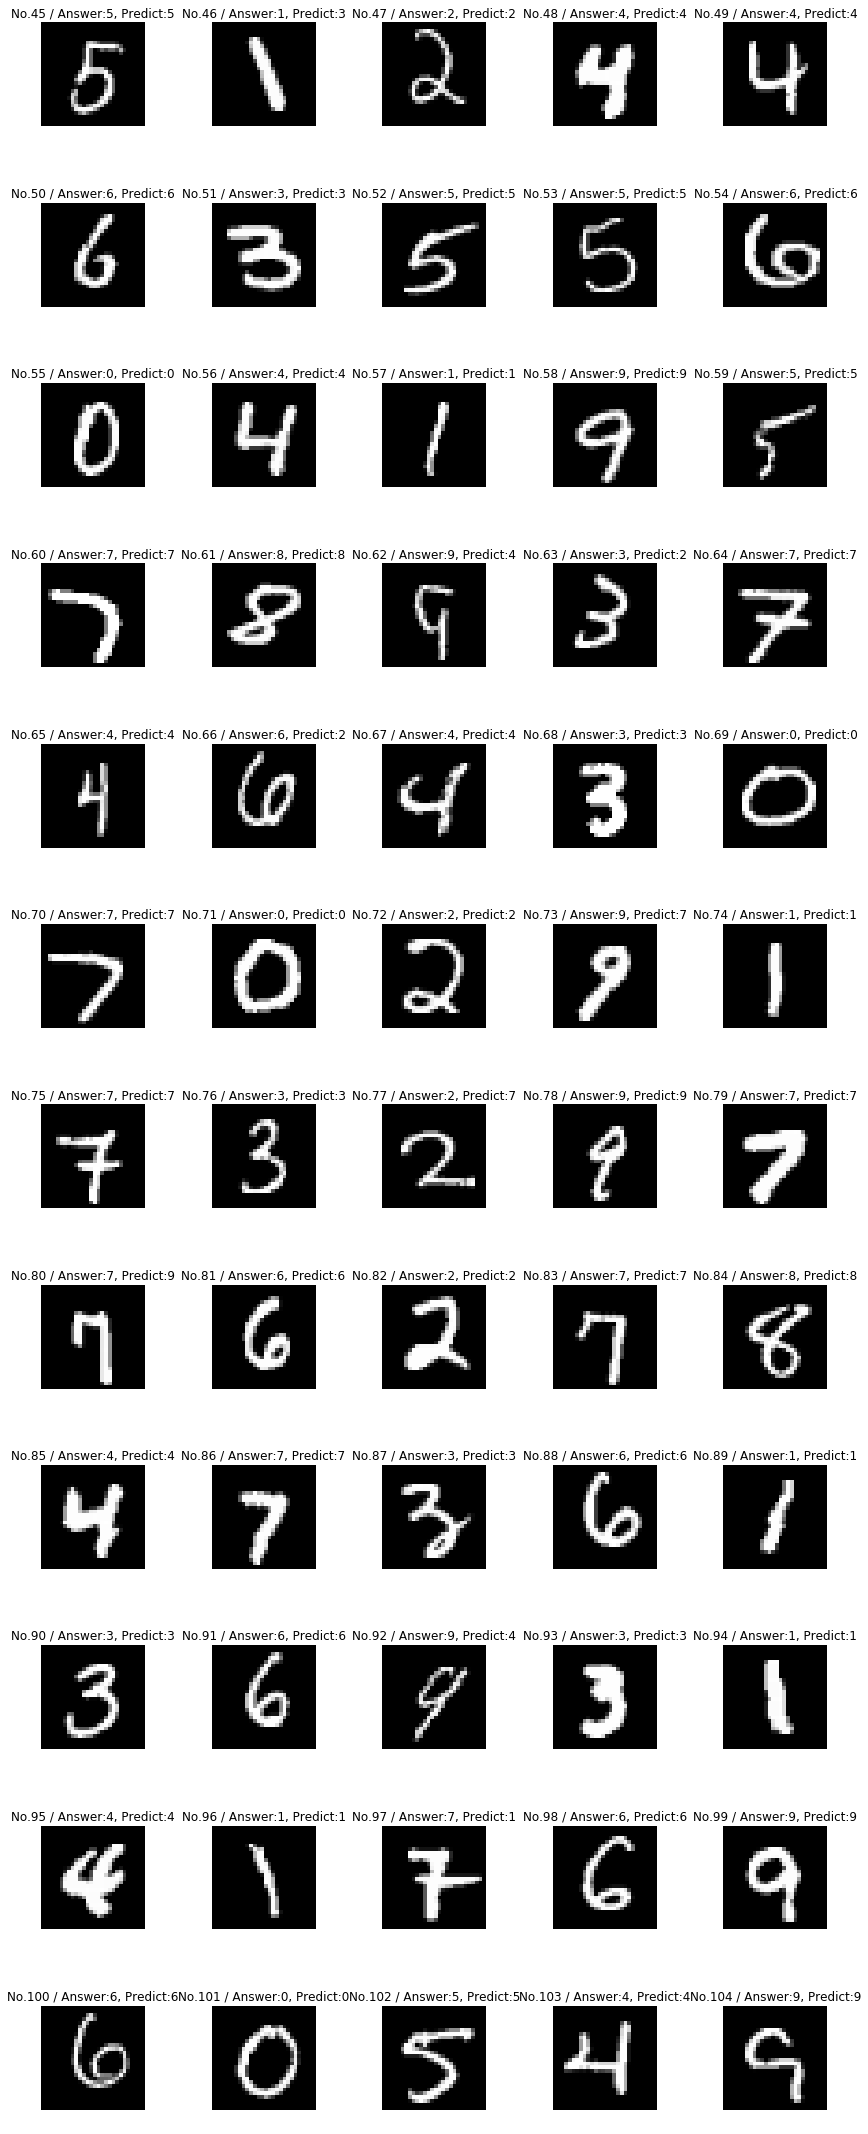

In [12]:
 plot_examples()

## Experiment 1.2 - Increase number of epochs

To improve the test accuracy, try to simply increase the number of epochs. Other conditions remain the same.

In [13]:
enable_cupy = False
n_epoch=5                 # Increased from 2 to 5
model = MLP2()

### Execution: run the new experiment with 5 epochs

Definitely it will take longer time.

In [14]:
train_and_test()

epoch       iteration   main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1           600         1.11994     0.656285              0.752233       0.8544                    
2           1200        0.566908    0.474532              0.864633       0.8855                    
3           1800        0.454592    0.406165              0.882783       0.8979                    
4           2400        0.403306    0.369879              0.891767       0.9038                    
5           3000        0.372927    0.34582               0.897933       0.9078                    
Elapsed time: 71.609


### Evaluation: find that the accuracy becomes higher

The loss is smaller and the validation/main/accuracy is higher (0.90+) than the previous experiment.

### Execution: find which mistakes have been removed

No.46 and/or No.54 can be correctly classified this time

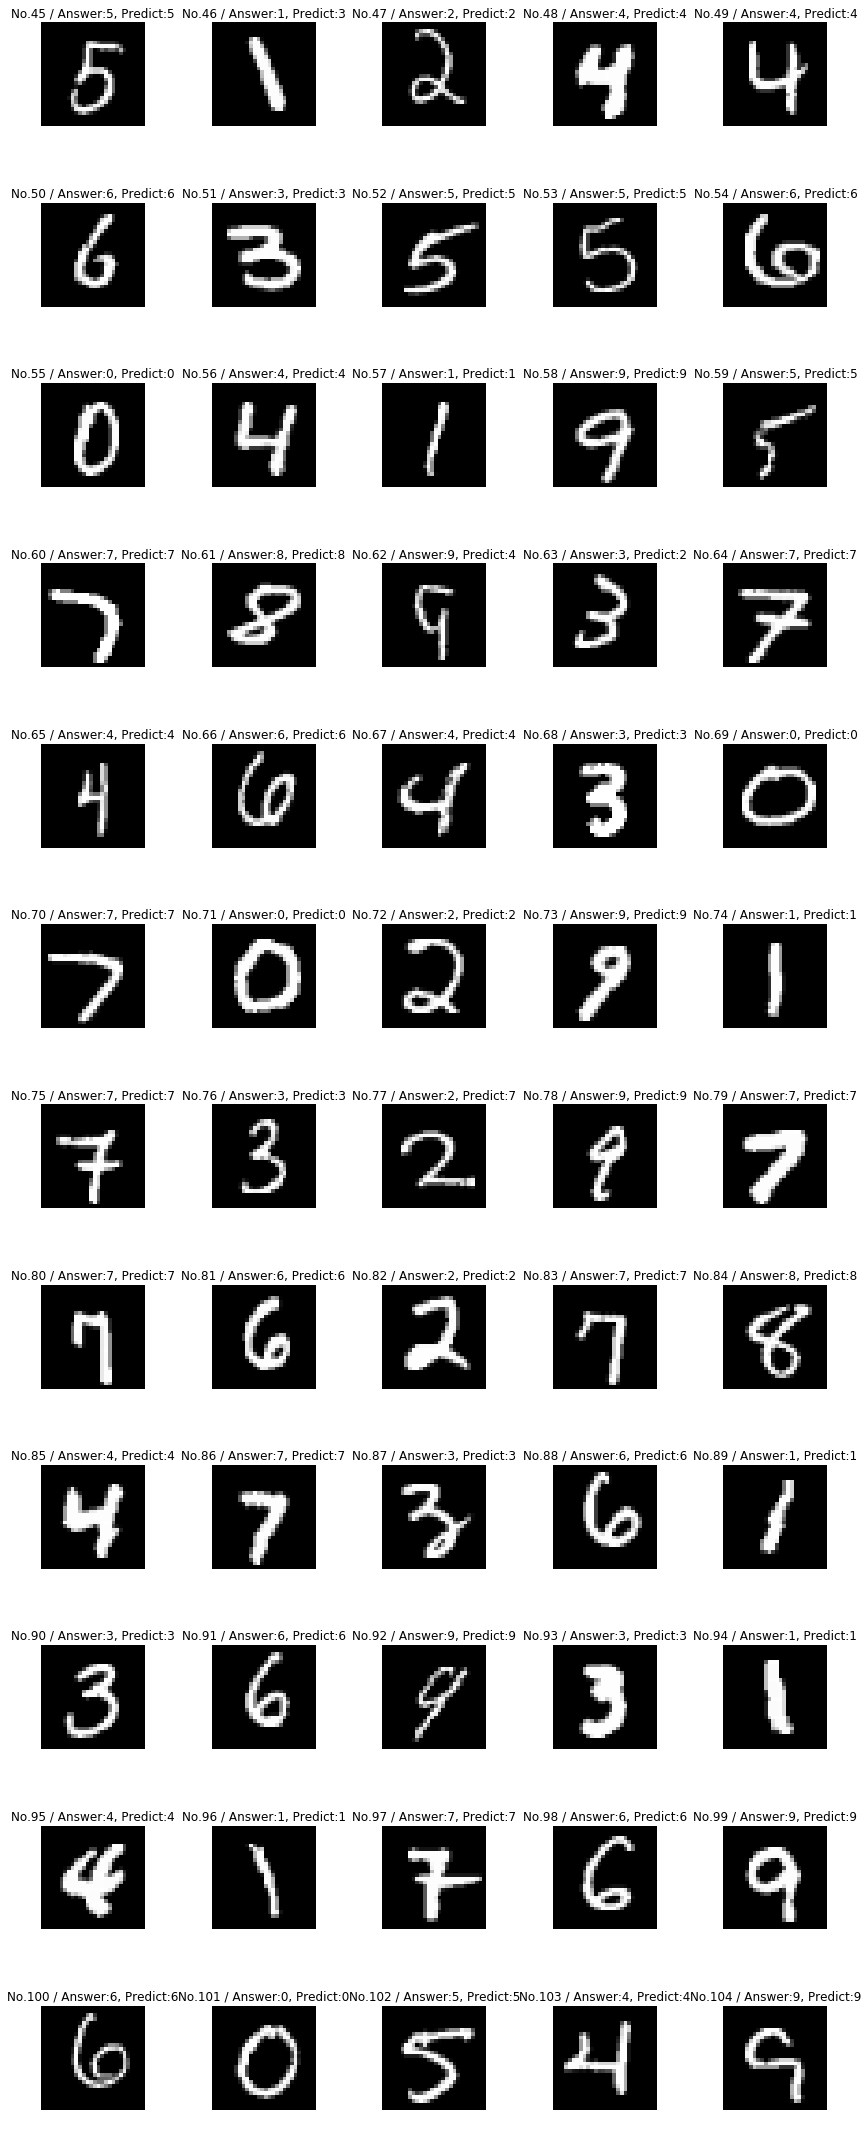

In [15]:
plot_examples()

## Experiment 1.3 - Enable GPU computation with CuPy

Though adding more epochs can lead to higher accuracy, 5 epochs already takes more than one minute. In this case, we try to make it faster by enabling CuPy to use GPU.

In [16]:
enable_cupy = True # Now use CuPy
n_epoch=5
model = MLP2()

### Execution: train the same model using GPU

The speed of training is clearly different.

In [17]:
train_and_test()

epoch       iteration   main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1           600         1.09494     0.636447              0.758866       0.8621                    
2           1200        0.553932    0.464712              0.864917       0.8843                    
3           1800        0.44769     0.400075              0.882284       0.8942                    
4           2400        0.398802    0.364851              0.891801       0.9013                    
5           3000        0.369477    0.342614              0.8984         0.9079                    
Elapsed time: 8.144


### Evaluation: compare the training time

GPU-enabled training should be 5+ times faster than CPU.

## Experiment 1.4 - Add one more layer

Then we use a different MLP with one more layer.

### Definition: MLP with 3 layers

MLP3 has two hidden units of same size (100 nodes), which are also connected with additional L.Linear. The forward computation is almost the same with MLP2 to use tanh as activation functions.

In [18]:
# 3-layer multi-Layer Perceptron (MLP)
class MLP3(Chain):
    
    def __init__(self):
        super(MLP3, self).__init__(
            l1=L.Linear(784, 100),
            l2=L.Linear(100, 100),   # Additional  layer
            l3=L.Linear(100, 10)
        )
        
    def __call__(self, x):
        h1 = F.tanh(self.l1(x))   # Hidden unit 1
        h2 = F.tanh(self.l2(h1)) # Hidden unit 2
        y = self.l3(h2)
        return y

### Preparation: create MLP3-based classifier model

In [19]:
enable_cupy = True
n_epoch=5
model = MLP3()  # Use MLP3 instead of MLP2

### Execution: train new MLP3-based model

In [20]:
train_and_test()

epoch       iteration   main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1           600         1.08521     0.584833              0.756399       0.8662                    
2           1200        0.501815    0.416795              0.873851       0.892                     
3           1800        0.400814    0.357343              0.891717       0.9026                    
4           2400        0.35619     0.325953              0.900734       0.9099                    
5           3000        0.329185    0.30527               0.9067         0.9148                    
Elapsed time: 9.330


### Evaluation: compare the accuracy of MLP3 with MLP2

MLP3 can achieve smaller loss and  higher accuracy thanks to its higher expressiveness. On the other hand, the computation time slightly increases for handling more parameters.

### Execution: see the computational graph with 3 layers

It contains 3 LinearFunction and 2 Tanh activations.

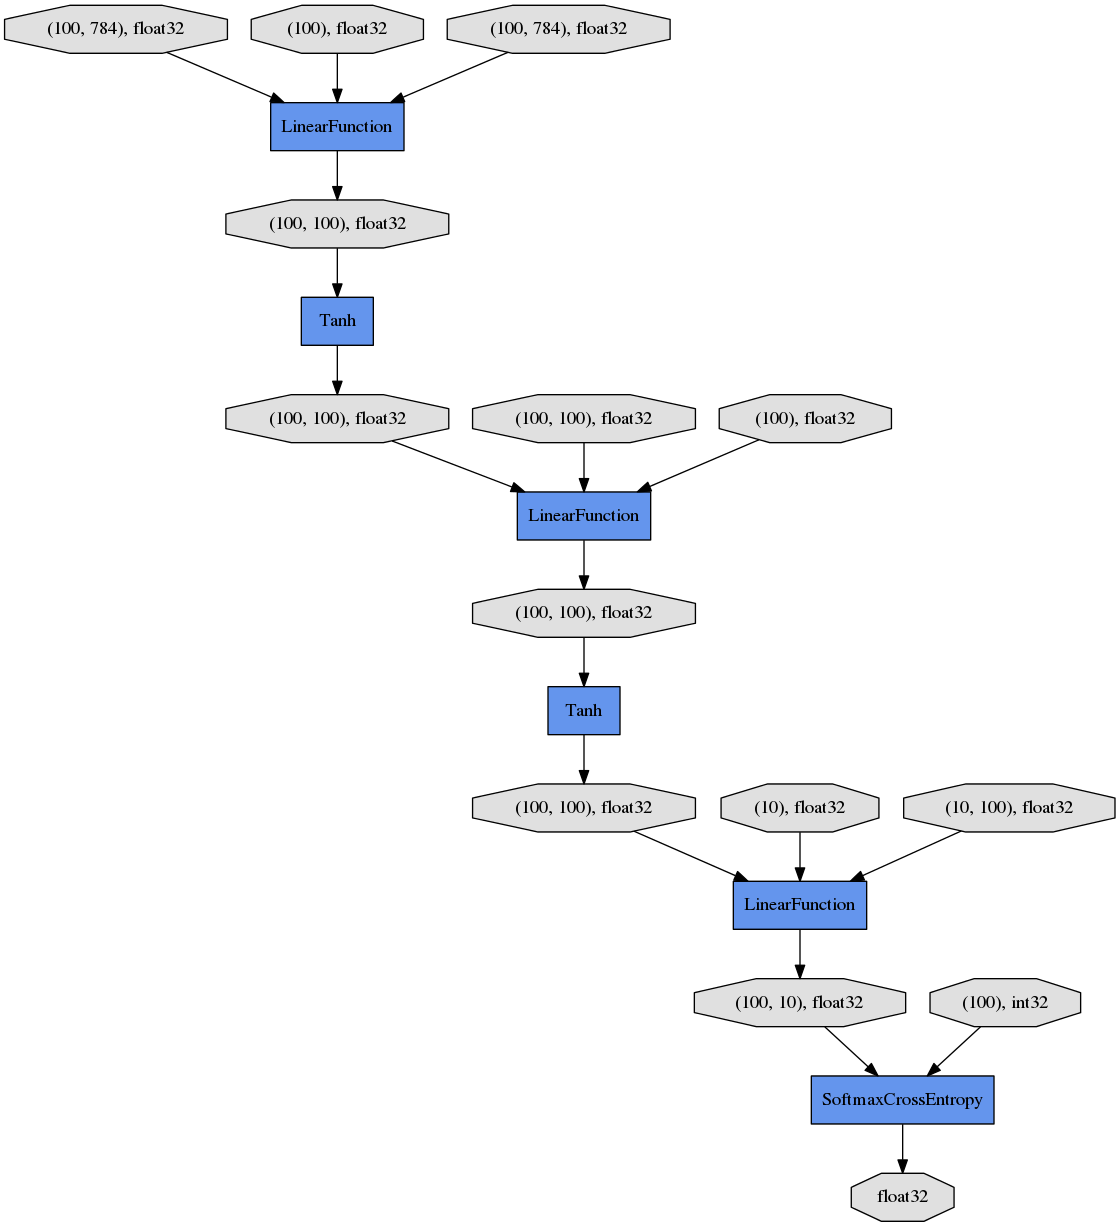

In [21]:
display_graph()

### Execution: can you find any misclassified samples?

MLP3 is good enough to predict the labels of most of the samples.

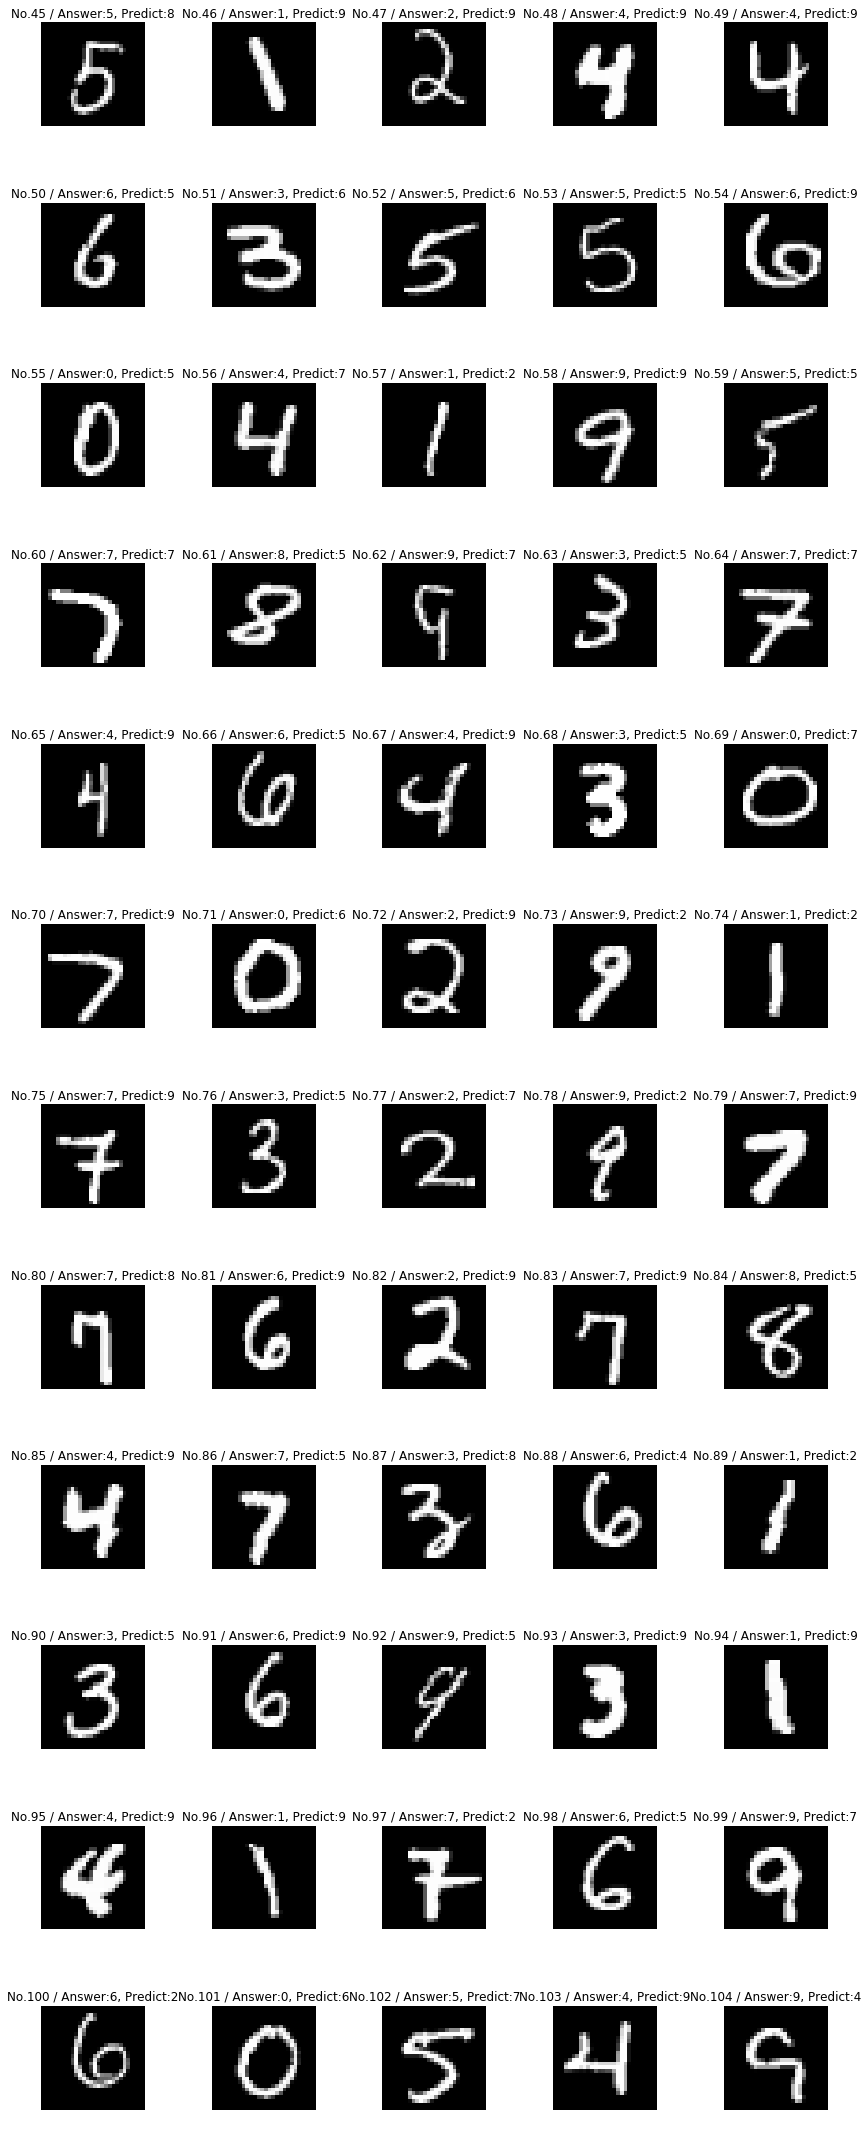

In [22]:
plot_examples()

## Chainer's feature - (1) Easy debug

Debugging complex neural networks is hard because runtime errors of other frameworks usually do not directly tell which part of model definition or implementation is wrong. However, Chainer supports type check in forward computation, so that debugging neural networks can be done just like debugging programs.

### Definition: an enbugged version of MLP

In MLP3Wrong, three bugs were introduced into MLP3. Let's find them during the execution and correct one by one later.

In [23]:
# Find three bugs in this model definition
class MLP3Wrong(Chain):
    
    def __init__(self):
        super(MLP3Wrong, self).__init__(
            l1=L.Linear(748, 100),
            l2=L.Linear(100, 100),
            l3=L.Linear(100, 10) 
        )

    def __call__(self, x):
        h1 = F.tanh(self.l1(x))
        h2 = F.tanh(self.l2(x))
        y = self.l3(h3)
        return y
    
enable_cupy = True
n_epoch=5
model = MLP3Wrong() # MLP3Wrong

### Execution: find errors by reading stack trace

In the forward computation, the stack trace points out where the errors actually occur. This is done by the Define-by-Run approach of Chainer, in which the computational graph is directly constructed during forward computation.

If you finish correcting three bugs, MLP3Wrong must be exactly the same with the definition of MLP3.

In [24]:
train_and_test()

InvalidType: 
Invalid operation is performed in: LinearFunction (Forward)

Expect: prod(in_types[0].shape[1:]) == in_types[1].shape[1]
Actual: 784 != 748

## Experiment 1.5 - Make your own model

Now it is your turn. Let's modify the model by yourself to achieve higher accuracy.

Since increasing the number of epochs is obviously the easiest way, try to reach 0.95+ within 10 epochs & less than 100 sec. training.

### Definition: define a new model with more options

Tune the neural network model for better performance. There are many options:

* Increase the number of epochs
* Increase the number of nodes
* Add more layers
* Use different types of activation functions

In [25]:
# Let's create new Multi-Layer Perceptron (MLP)
class MLPNew(Chain):
    
    def __init__(self):
        # Add more layers?
        super(MLPNew, self).__init__(
            l1=L.Linear(784, 100),  # Increase output node as (784, 200)?
            l2=L.Linear(100, 100),  # Increase nodes as (200, 200)?
            l3=L.Linear(100, 10)      # Increase nodes as (200, 10)?
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))        # Replace F.tanh with F.sigmoid  or F.relu ?
        h2 = F.relu(self.l2(h1))        # Replace F.tanh with F.sigmoid  or F.relu ?
        y = self.l3(h2)
        return y

enable_cupy = True #  Use CuPy for faster training
n_epoch = 5 # Add more epochs?
model = MLPNew()

### Execution: create a better model with 0.95+ accuracy

In [26]:
train_and_test()

epoch       iteration   main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1           600         1.26941     0.581494              0.696516       0.8543                    
2           1200        0.479818    0.39022               0.874883       0.8941                    
3           1800        0.378399    0.338384              0.894484       0.9056                    
4           2400        0.337293    0.310017              0.904701       0.9132                    
5           3000        0.31162     0.289366              0.910918       0.919                     
Elapsed time: 9.405


### Execution: no mistake anymore?

With 0.95+ accuracy, you may not find any misclassification in these 60 examples.

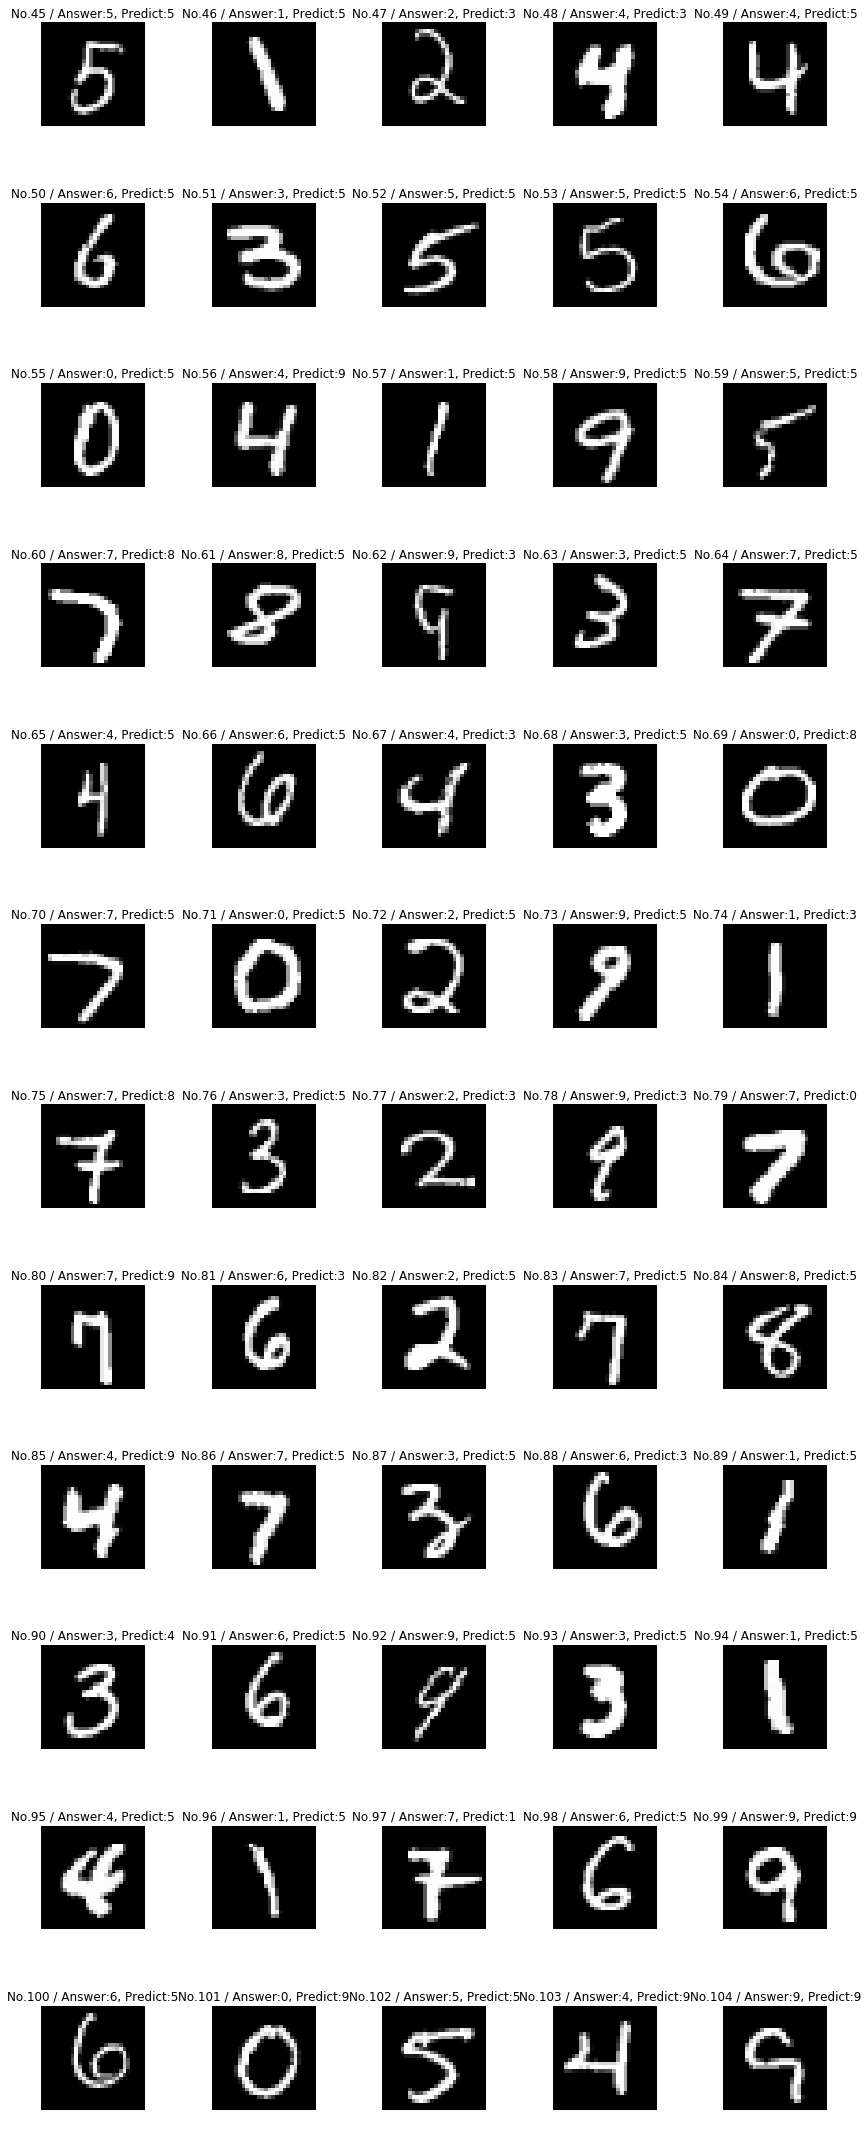

In [27]:
plot_examples()

### Execution: see how your best model looks like

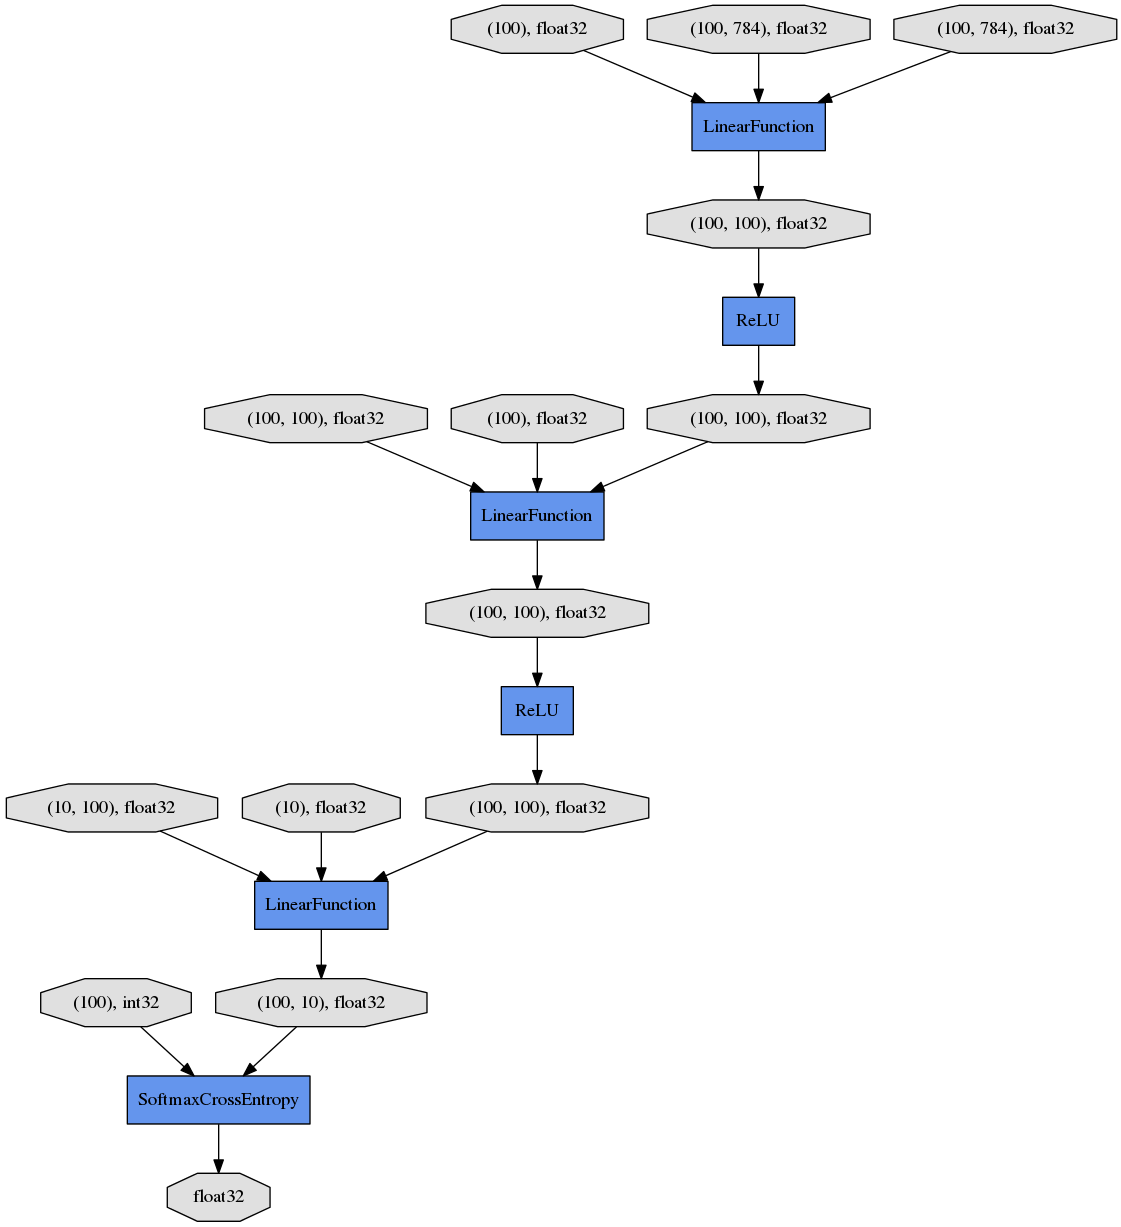

In [28]:
display_graph()

## Advanced: Convolutional NN implementation

In this Section, we only used MLP with linear (fully-connected) layers. However, recent progress of deep learning in image recognition comes from a different type of network called Convolutional Neural Network (CNN).

Though it is beyond the scope of this hands-on, Chainer also include an [example code](https://github.com/pfnet/chainer/tree/master/examples/imagenet) for ImageNet classification that contains many variants of CNN.

### Definition: AlexNet (ImageNet 2012 winner) model

AlexNet is the standard CNN that was used for winning ImageNet 2012 classification contest.

Chainer supports all of the commonly-used layers and functions so that users can re-implement such state-of-the-art models and extend it for their own problems. For example, AlexNet includes:

* Convolutional layer (L.Convolution2D)
* Max pooling (F.max_pooling_2d)
* Local response normalization (F.local_response_normalization)
* Dropout (F.dropout)

For more details on the functions, please refer to [Standard Function implementations](http://docs.chainer.org/en/stable/reference/functions.html) in Chainer reference manual.

In [29]:
# Definition of AlexNet
class AlexNet(chainer.Chain):

    def __init__(self):
        super(AlexNet, self).__init__(
            conv1=L.Convolution2D(3,  96, 11, stride=4),
            conv2=L.Convolution2D(96, 256,  5, pad=2),
            conv3=L.Convolution2D(256, 384,  3, pad=1),
            conv4=L.Convolution2D(384, 384,  3, pad=1),
            conv5=L.Convolution2D(384, 256,  3, pad=1),
            fc6=L.Linear(9216, 4096),
            fc7=L.Linear(4096, 4096),
            fc8=L.Linear(4096, 1000),
        )
        self.train = True
        
    def __call__(self, x, t):
        self.clear()
        h = F.max_pooling_2d(F.relu(
            F.local_response_normalization(self.conv1(x))), 3, stride=2)
        h = F.max_pooling_2d(F.relu(
            F.local_response_normalization(self.conv2(h))), 3, stride=2)
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = F.max_pooling_2d(F.relu(self.conv5(h)), 3, stride=2)
        h = F.dropout(F.relu(self.fc6(h)), train=self.train)
        h = F.dropout(F.relu(self.fc7(h)), train=self.train)
        y = self.fc8(h)
        return y

----------------------

# Section 2. Inside Chainer

In Section 1, we showed how to build and train neural networks in Chainer through image recognition. Users can also apply Chainer to their own problems other than such pattern recognition tasks.

Though we only combined preset layers and functions to build neural networks in the experiments, users may need to create new kinds of networks, by writing code for lower level of implementations, from scratch.

Chainer is designed to encourage users to rapidly make such prototype of new models, test it, and improve through trial-and-error. In the following, we explain the core components inside the Chainer.

## 3.1 NumPy and CuPy

NumPy is the widely-used library in Python for numerical computations based on CPU. On the other hand, neural networks can benefit from GPU for faster computatins of multi-dimensional arrays. However, NumPy does not support GPU so that Python users have to write GPU-specific code as in the initial version of Chainer.

Therefore, CuPy has been created and added to Chainer as a NumPy-compatible library based on CUDA. It currently supports many of the APIs in NumPy so that users can write CPU/GPU-agnostic code in most cases.

### Execution: test NumPy

By using NumPy, create a matrix of size 1000x1000, transpose it, multiply 2 to each element, and repeat them for 5000 times.

In [30]:
# import numpy as np
a = np.arange(1000000).reshape(1000, -1)
t1 = time.clock()
for i in range(5000):
    a = np.arange(1000000).reshape(1000, -1)
    b = a.T * 2
t2 = time.clock()
print(t2 -t1)

9.226373


### Execution: test CuPy

Execute the same computation with CuPy. It should be about 4 times faster than NumPy.

In [31]:
# import cupy as cp
a = cp.arange(1000000).reshape(1000, -1)
t1 = time.clock()
for i in range(5000):
    a = cp.arange(1000000).reshape(1000, -1)
    b = a.T * 2
t2 = time.clock()
print(t2 -t1)

1.151652


## Chainer's feature - (2) CPU/GPU-compatible array manipulation

Since CuPy provides the same interface as NumPy as possible, users can switch them without modifying computation logic as follows.

In [32]:
def xp_test(xp):
    a = xp.arange(1000000).reshape(1000, -1)
    t1 = time.clock()
    for i in range(5000):
        a = xp.arange(1000000).reshape(1000, -1)
        b = a.T * 2
    t2 = time.clock()
    print(t2 -t1)

enable_cupy = False
xp_test(np if not enable_cupy else cp)
enable_cupy = True
xp_test(np if not enable_cupy else cp) 

9.09571
1.146414


## 3.2 Variable and Function

Variable and Function are two basic classes in Chainer. As their names suggest, Variable represents the values of variables and Function represents a static function on Variable.

### Execution: Variable is a class for multi-dimensional arrays

Variable can be initialized with NumPy/CuPy-arrays and it will be stored in .data.

In [33]:
x = Variable(np.asarray([[0, 2],[1, -3]]).astype(np.float32))

print(type(x))
print(type(x.data))
print(x.data)

<class 'chainer.variable.Variable'>
<type 'numpy.ndarray'>
[[ 0.  2.]
 [ 1. -3.]]


### Execution: Variable can move between CPU and GPU

By calling to_gpu() and to_cpu(), the content in .data can be either of the array in NumPy or CuPy.

In [34]:
x.to_gpu()
print(type(x.data))
x.to_cpu()
print(type(x.data))

<type 'cupy.core.core.ndarray'>
<type 'numpy.ndarray'>


### Execution: Function is used for transforming Variables

The actual computation is defined in forward() method, and the output must be also an instance of Variable.

In [35]:
from chainer import function

class MyFunc(function.Function):
    def forward(self, x):
        self.y = x[0] **2 + 2 * x[0] + 1 # y = x^2 + 2x + 1
        return self.y,

def my_func(x):
    return MyFunc()(x)

x = Variable(np.asarray([[0, 2],[1, -3]]).astype(np.float32))
y = my_func(x)
print(type(x))
print(x.data)
print(type(y))
print(y.data)

<class 'chainer.variable.Variable'>
[[ 0.  2.]
 [ 1. -3.]]
<class 'chainer.variable.Variable'>
[[ 1.  9.]
 [ 4.  4.]]


### Execution: Variable remembers history

Each instance of Variable remembers the function, which generates it, in .creator. If its .ceator is None, the Variable instance is called root.

In [36]:
x = Variable(np.asarray([[0, 2],[1, -3]]).astype(np.float32))

# y is created by MyFunc
y = my_func(x)
print(y.creator)

# z is created by F.sigmoid
z = F.sigmoid(x)
print(z.creator)

# x is created by user
print(x.creator)

None


### Variable natively supports backpropagation

Backpropagation is the standard way to optimize neural networks. After forward computation, the loss is given at the output (as gradient), then the corresponding gradients are assigned to each intermediate layer by backtracking the computational graph. Then the parameters will be updated using the gradient information.

<img src="image/backward.png" width="250">

In Chainer, since all of the variables in forward computation are stored and automatic differentiation is supported, backward() traces the computational graph backward from the terminal (output) to the root (input of which .creator is None). Then the optimizer updates the model.

### Definition: quadratic equation as forward computation

As shown in the previous section, forward computation can be regarded as a chain of functions to generate the final Variable instance. During the computation, Chainer remembers all of the intermediate Variable instances.

In [37]:
# A mock of forward computation
def forward(x):
    z = 2 * x
    y = x ** 2 - z + 1
    return y, z

### Execution: backward computation to assign gradients

By setting y.grad and call y.backward(), the gradient information will be transferred to x and z.

In [38]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]], dtype=np.float32))
y, z = forward(x)
y.grad = np.ones((2, 3), dtype=np.float32)
y.backward(retain_grad=True)

In [39]:
# Gradient for x: 2*x - 2
print(x.grad)

[[  0.   2.   4.]
 [  6.   8.  10.]]


In [40]:
# Gradient for z: -1
print(z.grad)

[[-1. -1. -1.]
 [-1. -1. -1.]]


## 3.3 Link and Chain

Function can represent a specific computation but it does not have any internal state. So it cannot be directly used for stateful elements in neural networks such as layers, of which states are used to represent the parameters.

Link is used as a wrapper to such Functions, with parameters. It is convenient to use Link as a reusable part to build a large network (an instance of Chain).  Many of the common layers are provided under [chianer.links](http://docs.chainer.org/en/stable/reference/links.html). They can be used as L.XYZ, just like L.Linear.

### Execution: Link is a stateful function with parameters

Most of the constructors of Link classes receive a few numbers to define the size of internal parameters. The parameters are also instances of Variable.

For example, L.Linear contains two parmeters, weight matrix W and bias term b. The constractor of L.Linear requires two values to specify the size of weight matrix and bias term.

In [41]:
f = L.Linear(3, 2)
# Weight matrix for linear transformation (randomly initialized)
print(f.W.data)
# Bias term for linear transformation (initialized with zero)
print(f.b.data)

[[-0.03568096 -0.66177195  0.01599928]
 [-0.04694187  0.33021313 -1.30938542]]
[ 0.  0.]


### Execution: use instance of Link

The instance of Link can be called just like a function.

In [42]:
# Apply linear transformation f()
x = Variable(np.array([[1, 2, 3], [4, 5, 6]], dtype=np.float32))
y = f(x)
print(y.data)

[[-1.31122708 -3.31467199]
 [-3.35558796 -6.39301443]]


### Execution: compute gradient for Link

Since the parameters in Link are instances of Variable, the backward computation assigns gradients to them.

In [43]:
# Initialize gradients of f
f.zerograds()
# Set gradient of y (= loss)
y.grad = np.ones((2, 2), dtype=np.float32)
# Backward computation
y.backward()
# Gradient for f.W and f.b
print(f.W.grad)
print(f.b.grad)

[[ 5.  7.  9.]
 [ 5.  7.  9.]]
[ 2.  2.]


### Definition: Chain is a set of Links = a network

The following class is exactly the same with MLP2 in Section 1, but it actually inherits Chain. As a base class of neural network model, Chain supports parameter management, to_cpu() and to_gpu() for migration between CPU and GPU, save/load, etc. 

In [44]:
# 2-layer Multi-Layer Perceptron (MLP)
class MLP2(Chain):
    
    # Initialization of layers (Link)
    def __init__(self):
        super(MLP2, self).__init__(
            l1=L.Linear(784, 100),
            l2=L.Linear(100, 10),
        )

    # Forward computation by __call__
    def __call__(self, x):
        h1 = F.tanh(self.l1(x))
        y = self.l2(h1)
        return y

## Advanced: Define-by-Run scheme

In most of the existing deep learning frameworks, the model construction and training are two separate processes. In advance of training, a fixed computational graph for a model is built by parsing the model definition. Most of them use a text or symbolic style program to define a neural network. These definitions can be regarded as a kind of domain-specific language (DSL) for deep learning. Then, given a training dataset, actual training runs for updating the model. The following figure shows the two processes. We call it Define-and-Run scheme.

<img src="image/define-and-run.png" width="400">

The Define-and-Run is very straightforward, and good for optimizing the computational graph before training. On the other hand, it has some drawbacks. For example, it requires special syntax to implement recurrent neural networks. The memory efficiency might not be optimal since all of the computational graph should be stored on the main memory from the beginning to the end of training.

Therefore, Chainer uses another approach named Define-by-Run. The model definition is combined with training as actual forward computation builds the computational graph on the fly. It enables users to easily implement complex networks with loops and branching by using host language.  Modifications to the computational graph during the training such as truncated BPTT can also be done efficiently.

<img src="image/define-by-run.png" width="400">

We would like interested users to refer to our [research paper](http://learningsys.org/papers/LearningSys_2015_paper_33.pdf).

-----------------------

# Section 3. Summary

We introduced Chainer as a poweruful, intuitive and flexible framework for deep learning. Chainer enables users to easily implement complex models proposed by recent academic papers and also rapidly make a prototype of new algorithms by themselves.

The following images were generate by a [Chainer implementation](https://github.com/mattya/chainer-gogh) of a famous paper ["A neural algorithm of Artistic style"](http://arxiv.org/abs/1508.06576). The style of a content image of a cat is modified into artistic images of which style resembles the style images next to it.

<img src="image/gogh.png" width="500">

This is just an example, but you can see how this kind of fancy models are implemented in only a few hundreds of lines of codes in Chainer. There is also a list of [code examples](https://github.com/pfnet/chainer/wiki/External-examples) provided by users for many use-cases.

----------------------------------

This is the end of this hands-on. For more details, please refer to the [official tutorial](http://docs.chainer.org/en/stable/tutorial/index.html).